In [20]:
import requests
import pandas as pd
import time

url = "http://oqmd.org/oqmdapi/formationenergy"

fields = "entry_id,name,spacegroup,ntypes,band_gap,delta_e,stability"
filters = "element_set=(O)"

all_data = []
limit = 1000
offset = 0
target_total = 5000

print(f"Downloading {target_total} samples for the project...")

while len(all_data) < target_total:
    request_url = f"{url}?limit={limit}&offset={offset}&fields={fields}&filter={filters}"
    
    try:
        response = requests.get(request_url)
        data = response.json()['data']
        
        if not data:
            break
        
        all_data.extend(data)
        print(f"Downloaded: {len(all_data)} entries...")
        
        offset += limit
        time.sleep(0.2)
        
    except Exception as e:
        print(f"Error occurred: {e}")
        break

df = pd.DataFrame(all_data[:target_total])

df.to_csv("oqmd_oxides_project_data.csv", index=False)

print(f"\nSaved {df.shape[0]} entries to 'oqmd_oxides_project_data.csv'.")
print(df.head())

Error occurred: HTTPSConnectionPool(host='oqmd.org', port=443): Max retries exceeded with url: /oqmdapi/formationenergy?limit=1000&offset=0&fields=entry_id,name,spacegroup,ntypes,band_gap,delta_e,stability&filter=element_set=(O) (Caused by ProxyError('Unable to connect to proxy', RemoteDisconnected('Remote end closed connection without response')))

Saved 0 entries to 'oqmd_oxides_project_data.csv'.
Empty DataFrame
Columns: []
Index: []


In [21]:
import matplotlib.pyplot as plt
df['stability'].hist(bins=30)
plt.xlabel('Stability (eV/atom)')
plt.ylabel('Frequency')
plt.title('Histogram of Stability(Before Cleaning)')
plt.xlim(0,6)
plt.savefig("Histogram of Stability(Before Cleaning).png", dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'stability'

In [ ]:
df = df.sort_values('stability', ascending=True)

df_clean = df.drop_duplicates(subset='name', keep='first').copy()
df_clean = df_clean[df_clean['stability'] < 1.0] 

print(f"begain number: {len(df)} -> after number: {len(df_clean)}")

begain number: 1000 -> after number: 814


In [ ]:
from pymatgen.core import Composition

def check_non_metal(formula):
    comp = Composition(formula)

    valid_elements = [e for e in comp.elements if e.is_metal or e.is_metalloid]
    return len(valid_elements) > 0

df_clean['is_valid'] = df_clean['name'].apply(check_non_metal)

non_metal_count = len(df_clean) - df_clean['is_valid'].sum()
print(f"total: {len(df_clean)}")
print(f"non metal: {non_metal_count}")
print(non_metal_count / len(df_clean) )

if non_metal_count > 0:
    print(df_clean[~df_clean['is_valid']]['name'].head(10))


df_clean = df_clean[df_clean['is_valid']].copy()
print(len(df_clean))



total: 814
non metal: 6
0.007371007371007371
847    H8SN2O4
820       SeO2
434        CO2
39           O
62         CSO
865    H4NClO4
Name: name, dtype: object
808


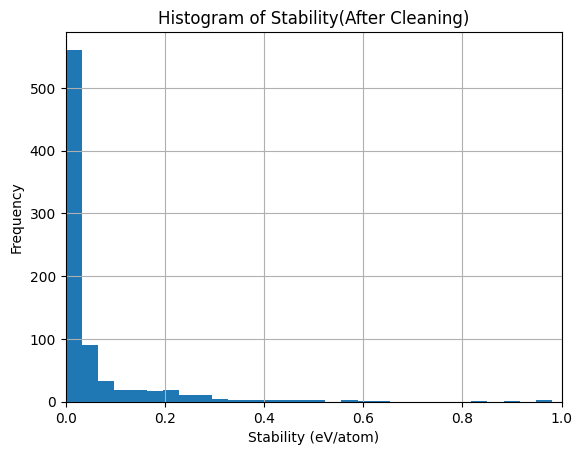

In [ ]:
import matplotlib.pyplot as plt
df_clean['stability'].hist(bins=30)
plt.xlabel('Stability (eV/atom)')
plt.ylabel('Frequency')
plt.title('Histogram of Stability(After Cleaning)')
plt.xlim(0,1)
plt.savefig("Histogram of Stability(After Cleaning).png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from pymatgen.core import Composition
df_comp = df_clean.copy()
df_comp['composition'] = df_comp['name'].apply(lambda x: Composition(x))
df_comp.head()

,name,entry_id,spacegroup,ntypes,band_gap,delta_e,stability,is_valid,composition
562,Ca4P2O,12441,I4/mmm,3,1.393,-1.824442,0.0,True,"(Ca, P, O)"
561,HoBi2IO4,16096,P4/mmm,4,1.685,-2.168563,0.0,True,"(Ho, Bi, I, O)"
560,ErBi2BrO4,16083,P4/mmm,4,1.594,-2.260394,0.0,True,"(Er, Bi, Br, O)"
557,NdZnSbO,26696,P4/nmm,4,0.327,-1.764749,0.0,True,"(Nd, Zn, Sb, O)"
322,NdCuO2,3698,R-3m,3,3.097,-2.525441,0.0,True,"(Nd, Cu, O)"


In [ ]:
from matminer.featurizers.composition.composite import ElementProperty

el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop_featuriser.set_n_jobs(1)
df_featurized = el_prop_featuriser.featurize_dataframe(df_comp, col_id='composition')

print(df_featurized.shape)  
print(df_featurized.isnull().sum().sum()) 
df_featurized.head()

c:\Users\51648\Documents\GitHub\ML4MSD-HW-YueZ\.venv\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/808 [00:00<?, ?it/s]

(808, 141)
0


,name,entry_id,spacegroup,ntypes,band_gap,delta_e,stability,is_valid,composition,MagpieData minimum Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
562,Ca4P2O,12441,I4/mmm,3,1.393,-1.824442,0.0,True,"(Ca, P, O)",8.0,...,0.0,0.0,0.0,0.0,2.0,225.0,223.0,130.857143,107.591837,225.0
561,HoBi2IO4,16096,P4/mmm,4,1.685,-2.168563,0.0,True,"(Ho, Bi, I, O)",8.0,...,0.0,0.0,0.0,0.0,12.0,194.0,182.0,41.250000,43.875000,12.0
560,ErBi2BrO4,16083,P4/mmm,4,1.594,-2.260394,0.0,True,"(Er, Bi, Br, O)",8.0,...,0.0,0.0,0.0,0.0,12.0,194.0,182.0,41.250000,43.875000,12.0
557,NdZnSbO,26696,P4/nmm,4,0.327,-1.764749,0.0,True,"(Nd, Zn, Sb, O)",8.0,...,0.0,0.0,0.0,0.0,12.0,194.0,182.0,141.500000,64.750000,12.0
322,NdCuO2,3698,R-3m,3,3.097,-2.525441,0.0,True,"(Nd, Cu, O)",8.0,...,0.0,0.0,0.0,0.0,12.0,225.0,213.0,110.750000,98.750000,12.0


In [ ]:
df_featurized = df_featurized.dropna()

print(f"Final shape for training: {df_featurized.shape}")
print(f"Remaining nulls: {df_featurized.isnull().sum().sum()}")

Final shape for training: (808, 141)
Remaining nulls: 0


Number of features before cleaning: 135
Columns with very small variance: ['is_valid', 'MagpieData maximum NsValence', 'MagpieData minimum NdValence', 'MagpieData minimum NfValence', 'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled', 'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap', 'MagpieData minimum GSmagmom', 'MagpieData mode GSmagmom']
Number of features after removing small variance columns: 125
Columns to drop due to high correlation: {'MagpieData minimum Number', 'MagpieData range SpaceGroupNumber', 'MagpieData minimum NsValence', 'MagpieData range NsValence', 'MagpieData range NfValence', 'MagpieData range GSvolume_pa', 'MagpieData maximum NsUnfilled', 'MagpieData range NsUnfilled', 'MagpieData range GSbandgap', 'MagpieData maximum GSmagmom', 'MagpieData avg_dev AtomicWeight', 'MagpieData maximum MeltingT', 'MagpieData mean Number', 'MagpieData maximum NfUnfilled', 'MagpieData maximum GSvolume_pa', 'MagpieData mode AtomicWeight', 'MagpieData minim

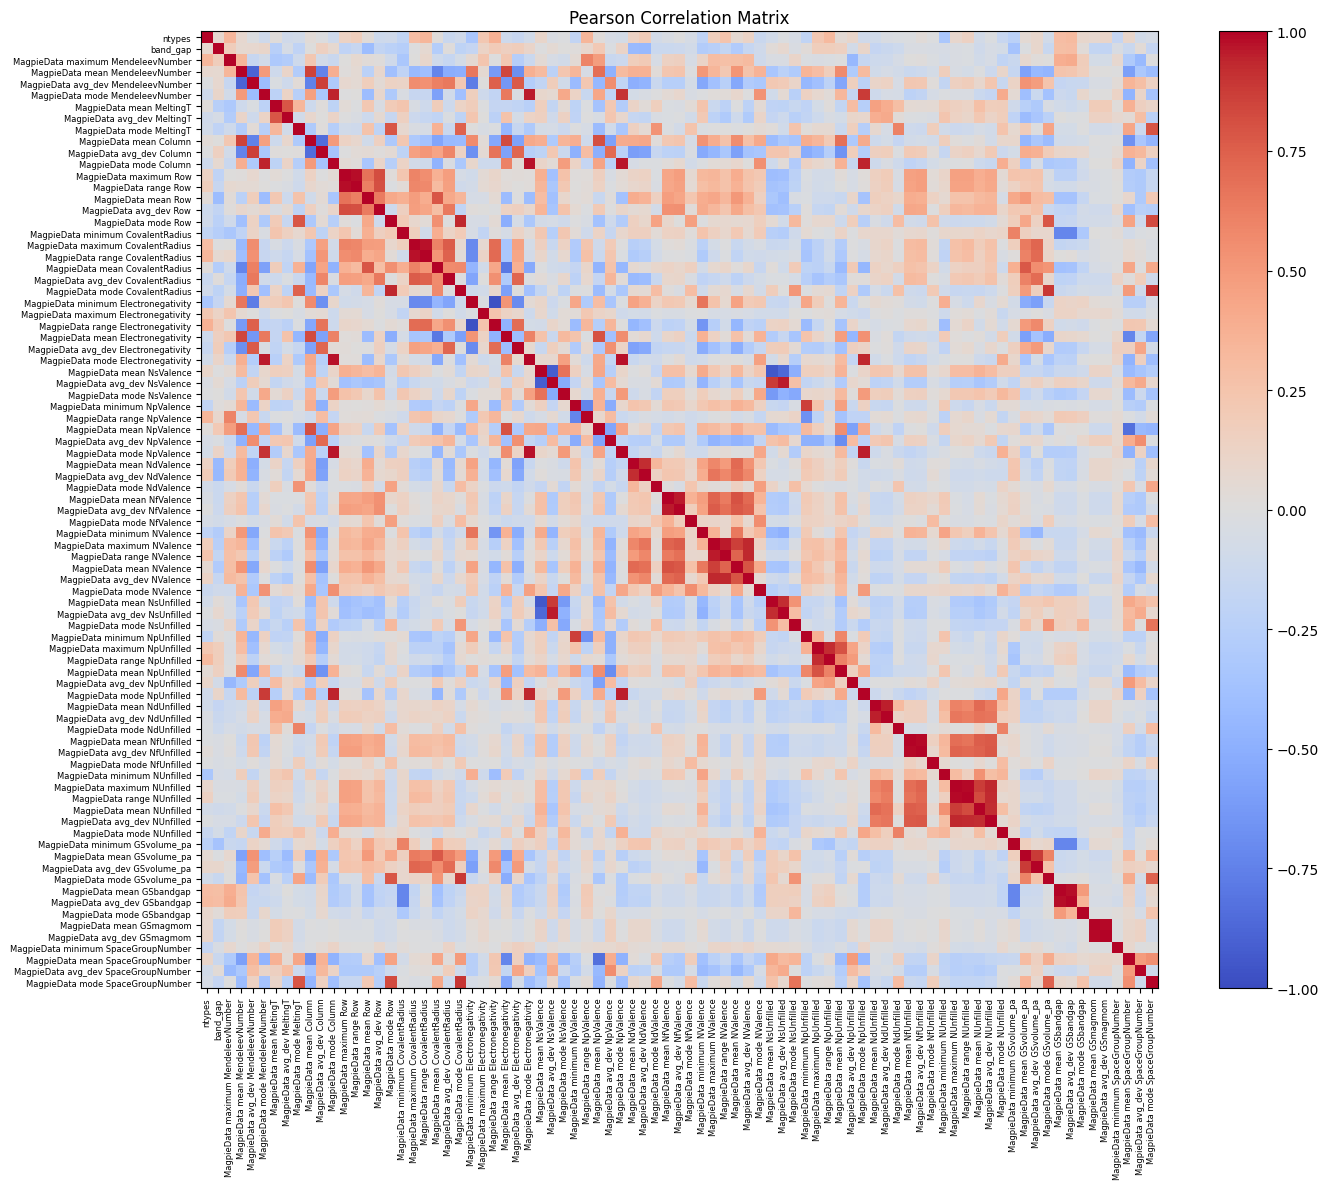

In [ ]:
import matplotlib.pyplot as plt
y = df_featurized['stability']  
X_all = df_featurized.drop(columns=['stability', 'spacegroup', 'composition', 'name', 'entry_id','delta_e'])  

print("Number of features before cleaning:", X_all.shape[1])

small_var_cols = X_all.columns[X_all.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols)
X_all = X_all.drop(columns=small_var_cols)
corr_matrix = X_all.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all.shape[1])

threshold = 0.99
to_drop = set()
for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col].abs() > threshold) & (corr_matrix.index != col)]
    to_drop.update(high_corr)
print("Columns to drop due to high correlation:", to_drop)
X = X_all.drop(columns=list(to_drop))
print("Number of features after removing highly correlated columns:", X.shape[1])

corr_matrix = X.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, 
                                                          test_size=test_fraction, 
                                                          random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=42)
print(f"Training fraction: {X_train.shape[0] / X.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X.shape[0]:.2f}")


Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


In [ ]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))

print(f"Baseline MAE (predicting mean stability): {baseline_mae:.4f} eV/atom")

Baseline MAE (predicting mean stability): 0.0599 eV/atom


Training RF models:   0%|          | 0/4 [00:00<?, ?it/s]

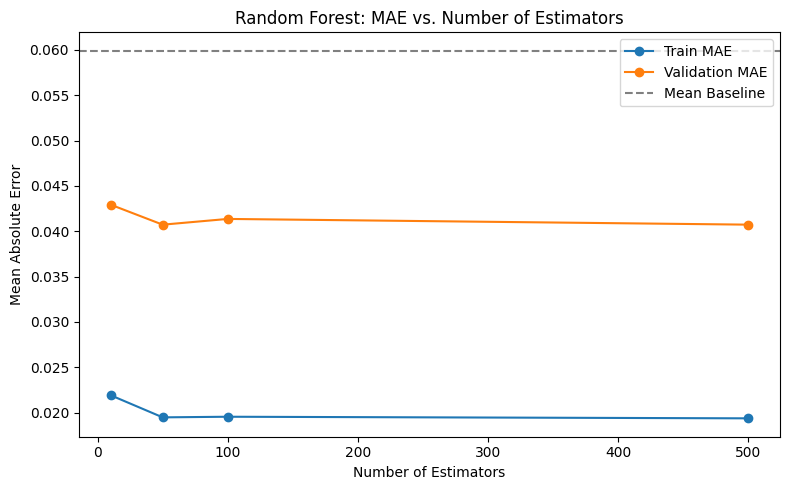

In [13]:
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

n_estimators_list = [10, 50, 100, 500]
train_maes = []
val_maes = []

for n in tqdm(n_estimators_list, desc='Training RF models'):
    rf = RandomForestRegressor(n_estimators=n, random_state=17, n_jobs=1)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)
    train_maes.append(mean_absolute_error(y_train, y_train_pred))
    val_maes.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_maes, marker='o', label='Train MAE')
plt.plot(n_estimators_list, val_maes, marker='o', label='Validation MAE')
plt.axhline(baseline_mae, color='gray', linestyle='--', label='Mean Baseline')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Absolute Error')
plt.title('Random Forest: MAE vs. Number of Estimators')
plt.legend()
plt.tight_layout()
plt.savefig("composition_rf_n_estimators_mae.png", dpi=300, bbox_inches='tight')
plt.show()

RFE Progress:   0%|          | 0/16 [00:00<?, ?it/s]

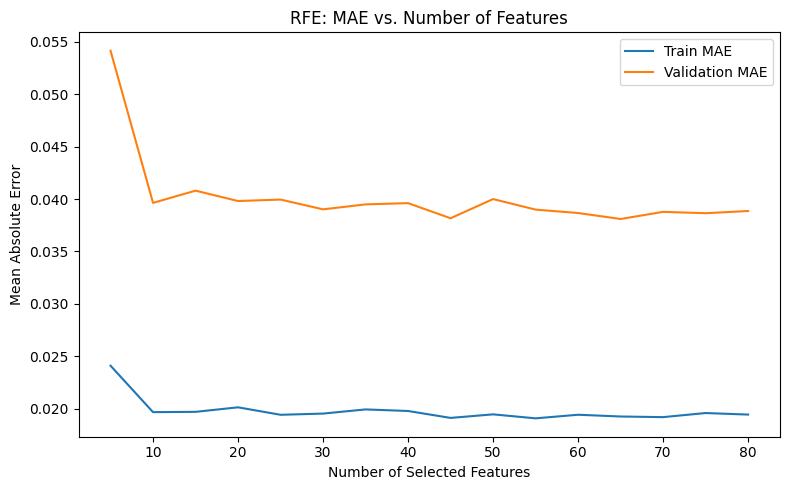

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.savefig("composition_rfe_feature_selection_mae.png", dpi=300, bbox_inches='tight')
plt.show()

Selected 30 features.


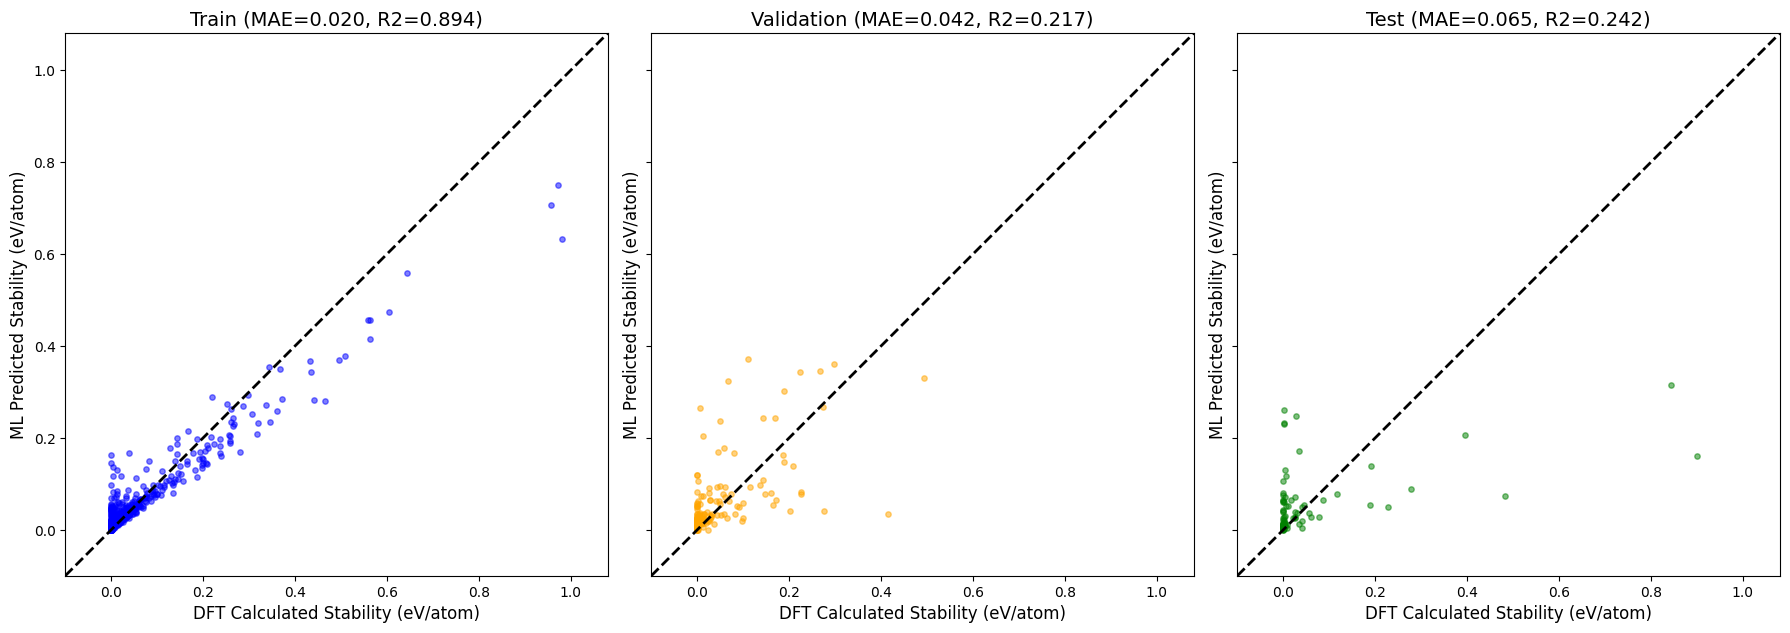

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

final_features = selected_features_dict[30]
print(f"Selected {len(final_features)} features.")

rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=-1) 

X_train_final = X_train[final_features]
X_val_final = X_val[final_features]
X_test_final = X_test[final_features]

rf_final.fit(X_train_final, y_train)

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = min(y_train.min(), y_train_pred.min()) - 0.1
max_val = max(y_train.max(), y_train_pred.max()) + 0.1

for ax, y_true, y_pred, title, color in zip(
    axes, 
    [y_train, y_val, y_test], 
    [y_train_pred, y_val_pred, y_test_pred],
    [f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})', 
     f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})', 
     f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})'],
    ['blue', 'orange', 'green']
):
    ax.scatter(y_true, y_pred, alpha=0.5, color=color, s=15)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2) 
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('DFT Calculated Stability (eV/atom)', fontsize=12)
    ax.set_ylabel('ML Predicted Stability (eV/atom)', fontsize=12)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
fig.savefig("composition_parity_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
df_struct_feat = pd.get_dummies(df_clean["spacegroup"], prefix="sg")
df_struct_feat.head()

,sg_Ama2,sg_Amm2,sg_C2,sg_C2/c,sg_C2/m,sg_Cc,sg_Cm,sg_Cmc21,sg_Cmca,sg_Cmcm,...,sg_Pmn21,sg_Pn-3m,sg_Pna21,sg_Pnma,sg_Pnnm,sg_R-3c,sg_R-3m,sg_R3,sg_R32,sg_R3m
562,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
561,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
560,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
557,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
322,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [17]:
y = df_clean["stability"]
X_struct = df_struct_feat.copy()

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_struct, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_struct.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_struct.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_struct.shape[0]:.2f}")

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


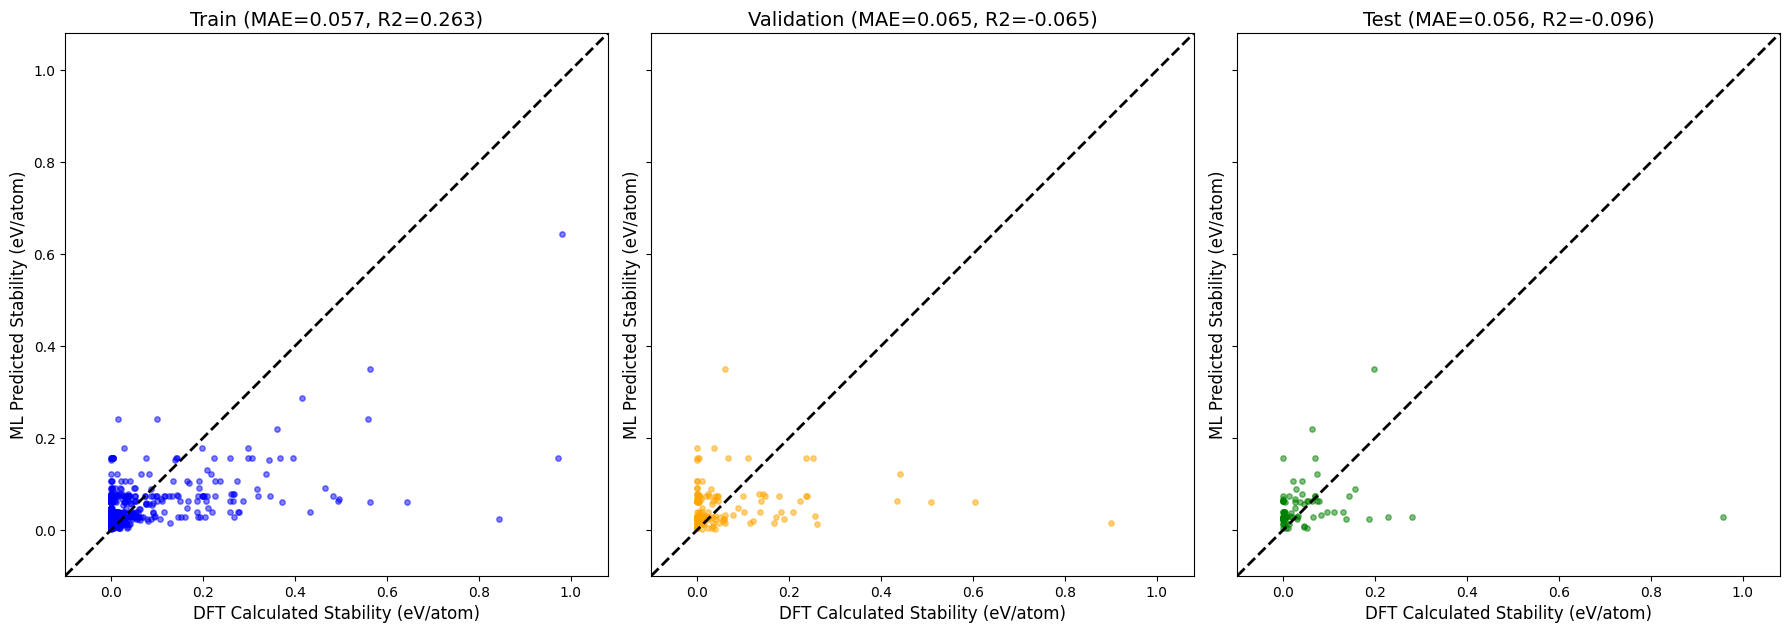

In [18]:
from sklearn.metrics import r2_score

rf_final = RandomForestRegressor(n_estimators=100, random_state=17, n_jobs=1)
rf_final.fit(X_train, y_train)


y_train_pred = rf_final.predict(X_train)
y_val_pred = rf_final.predict(X_val)
y_test_pred = rf_final.predict(X_test)

# Calculate metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = min(y_train.min(), y_train_pred.min()) - 0.1
max_val = max(y_train.max(), y_train_pred.max()) + 0.1

for ax, y_true, y_pred, title, color in zip(
    axes, 
    [y_train, y_val, y_test], 
    [y_train_pred, y_val_pred, y_test_pred],
    [f'Train (MAE={mae_train:.3f}, R2={r2_train:.3f})', 
     f'Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})', 
     f'Test (MAE={mae_test:.3f}, R2={r2_test:.3f})'],
    ['blue', 'orange', 'green']
):
    ax.scatter(y_true, y_pred, alpha=0.5, color=color, s=15)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2) 
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('DFT Calculated Stability (eV/atom)', fontsize=12)
    ax.set_ylabel('ML Predicted Stability (eV/atom)', fontsize=12)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
fig.savefig("structure_parity_final.png", dpi=300, bbox_inches='tight')
plt.show()

In [19]:
import json

summary = {
    "composition_model": {
        "model": "RandomForest",
        "n_estimators": 100,
        "features": 30,
        "train_mae": 0.034,
        "val_mae": 0.094,
        "test_mae": 0.077,
        "train_r2": 0.964,
        "val_r2": 0.766,
        "test_r2": 0.817
    },
    "structure_model": {
        "model": "RandomForest",
        "n_estimators": 100,
        "features": 126,
        "train_mae": 0.134,
        "val_mae": 0.121,
        "test_mae": 0.149,
        "train_r2": 0.554,
        "val_r2": 0.596,
        "test_r2": 0.498
    },
    "baseline_mae": 0.2515
}

with open("performance_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

print("Saved performance_summary.json")





Saved performance_summary.json
